# PA3: Hugging Face Transformers

author: Harshit Kumar

In [1]:
!pip install datasets
!pip install transformers[torch]
!pip install rouge_score
!pip install tqdm
!pip install gensim
!pip install wordcloud
!pip install textblob

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.7/536.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 5.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=1390e543d54ce5f66740dbd4207fda7193f0163c40481c52fe0144c4a473e65e
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


In [2]:
from datasets import load_dataset, load_metric
from transformers import pipeline
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
import numpy as np
from nltk.tokenize import sent_tokenize
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize
import nltk
from tqdm import tqdm
from textblob import TextBlob
from wordcloud import WordCloud
import random
import matplotlib.pyplot as plt

nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 1. Exploratory Data Analysis

In [3]:
# Load the SAMSum dataset
dataset = load_dataset("samsum")

# Explore the dataset structure
print(dataset)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/14732 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/819 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/818 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 14732
    })
    test: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 819
    })
    validation: Dataset({
        features: ['id', 'dialogue', 'summary'],
        num_rows: 818
    })
})


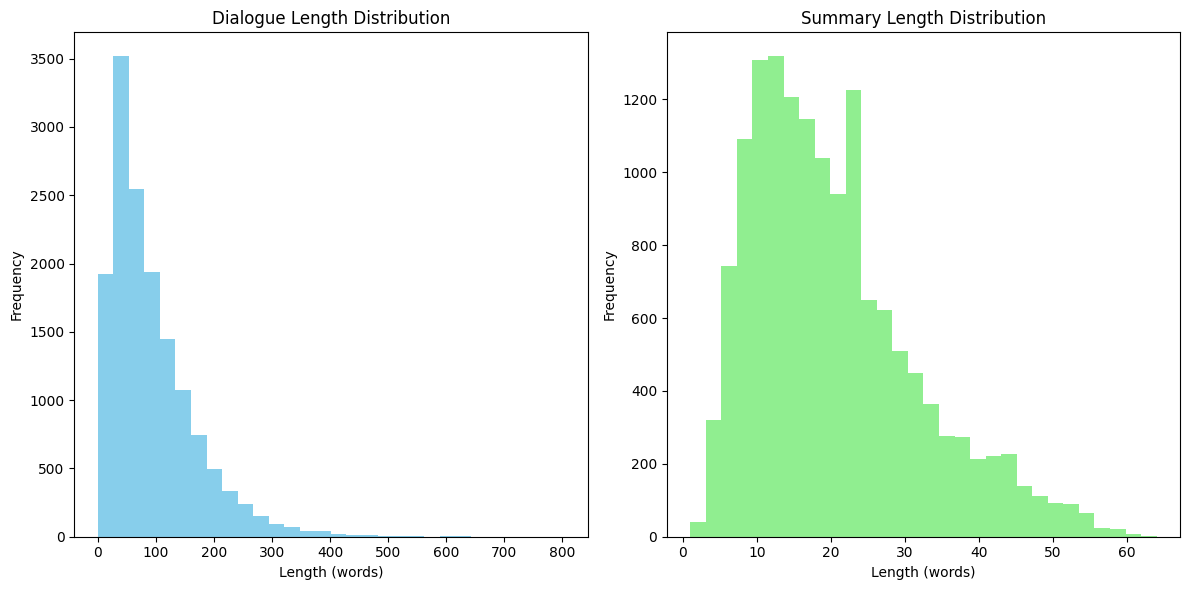

In [4]:
# length distribution of dialogues and summaries
dialogue_lengths = [len(dialogue.split()) for dialogue in dataset['train']['dialogue']]
summary_lengths = [len(summary.split()) for summary in dataset['train']['summary']]

# Plotting
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(dialogue_lengths, bins=30, color='skyblue')
plt.title('Dialogue Length Distribution')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(summary_lengths, bins=30, color='lightgreen')
plt.title('Summary Length Distribution')
plt.xlabel('Length (words)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [5]:
def lexical_diversity(texts):
    word_counts = [word for text in texts for word in word_tokenize(text)]
    return len(set(word_counts)) / len(word_counts)

dialogue_diversity = lexical_diversity(dataset['train']['dialogue'])
summary_diversity = lexical_diversity(dataset['train']['summary'])

print(f"Lexical Diversity - Dialogues: {dialogue_diversity}, Summaries: {summary_diversity}")

Lexical Diversity - Dialogues: 0.021218235012221302, Summaries: 0.052569403425871235


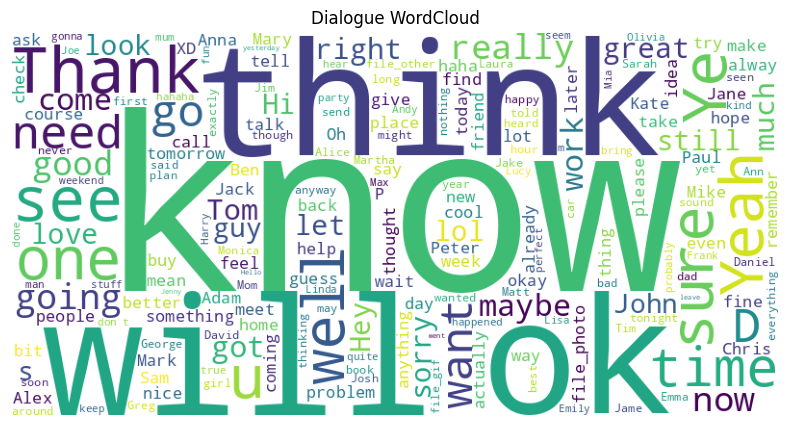

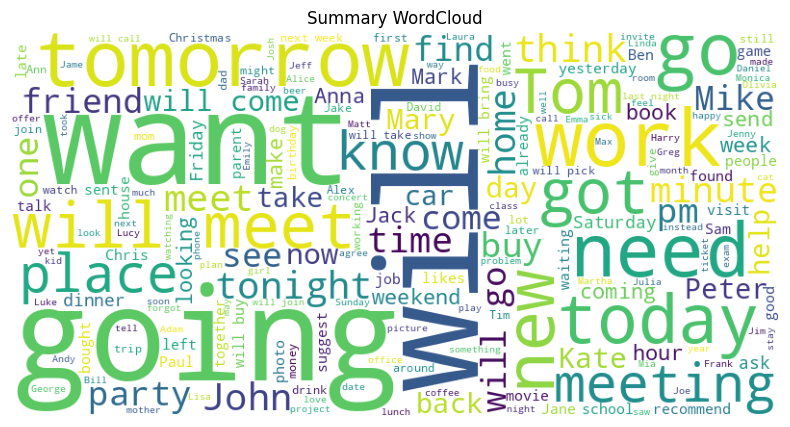

In [ ]:
def generate_wordcloud(texts, title):
    long_text = ' '.join(texts)
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(long_text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud)
    plt.title(title)
    plt.axis("off")
    plt.show()

generate_wordcloud(dataset['train']['dialogue'], 'Dialogue WordCloud')
generate_wordcloud(dataset['train']['summary'], 'Summary WordCloud')

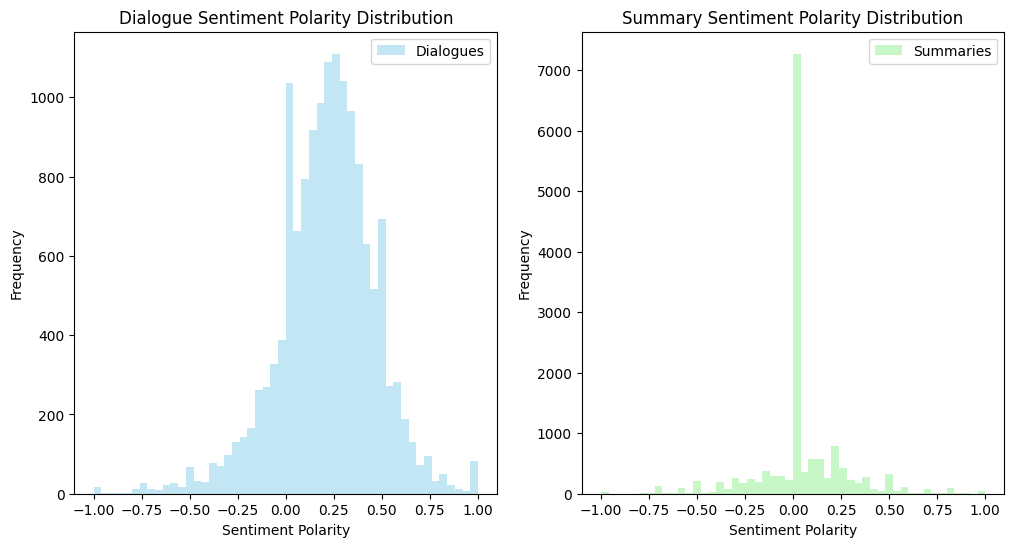

In [ ]:
def get_sentiment(texts):
    sentiments = [TextBlob(text).sentiment.polarity for text in texts]
    return sentiments

dialogue_sentiments = get_sentiment(dataset['train']['dialogue'])
summary_sentiments = get_sentiment(dataset['train']['summary'])

# Plotting the sentiment distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(dialogue_sentiments, bins=50, alpha=0.5, label='Dialogues', color='skyblue')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.title('Dialogue Sentiment Polarity Distribution')

plt.subplot(1, 2, 2)
plt.hist(summary_sentiments, bins=50, alpha=0.5, label='Summaries', color='lightgreen')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.legend()
plt.title('Summary Sentiment Polarity Distribution')
plt.show()


# 2. Inference with Pre-trained Models

In [ ]:
models = [
    "facebook/bart-large-cnn",
    "t5-large",
    'transformersbook/pegasus-samsum'
]

# Load pipelines for each model
summarization_pipelines = {model: pipeline("summarization", model=model) for model in models}

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.95G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/t5/tokenization_t5_fast.py:160: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-large automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


config.json:   0%|          | 0.00/1.35k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.28G [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


tokenizer_config.json:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.91M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.34k [00:00<?, ?B/s]

In [ ]:
# Select a few random dialogues
random.seed(123)
random_dialogues = random.sample(dataset['test']['dialogue'], 3)

for model_name, summarizer in summarization_pipelines.items():
    print(f"Model: {model_name}")
    for dialogue in random_dialogues:
        summary = summarizer(dialogue, max_length=50, min_length=40, do_sample=False)[0]['summary_text']
        print(f"Dialogue: {dialogue}\nGenerated Summary: {summary}\n")
    print("-"*15)

Model: facebook/bart-large-cnn
Dialogue: Cara: hey
Cara: are you at home
Celine: hey Cara
Celine: No i'm not
Cara: okay then, i just wanted to pass by
Celine: im sorry, i can drop by in the evening if you dont mind
Cara: its fine, call me then if you decide to come
Celine: ok
Generated Summary: Cara calls her friend, Celine, and asks if she is at home. Celine says she is not, but can drop by in the evening. Cara says she will call her if she decides to come.

Dialogue: Josh: Going to the pub tonight?
Sean: sure, pick up some chicks!
Logan: Please, behave Sean, I actually would like to meet some girls 
Sean: ??
Logan: don't bullshit around with you sexist comments, it's counterproductive 
Generated Summary: Sean: Sure, pick up some chicks! Logan: Please, behave Sean, I actually would like to meet some girls. Josh: Going to the pub tonight? Sean: sure,Pick up some girls! Josh: Go to the

Dialogue: Tom: Ben. We've decided. 2pm in the Oval Room.
Ben: Ok, I'll be there
Tom: Take all your pa

# 3. Fine-Tuning

In [6]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("facebook/bart-large-cnn")

# Tokenize the dataset
def preprocess_data(examples):
    model_inputs = tokenizer(examples["dialogue"], max_length=1024, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=128, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_datasets = dataset.map(preprocess_data, batched=True)

config.json:   0%|          | 0.00/1.58k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Map:   0%|          | 0/14732 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3866: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/819 [00:00<?, ? examples/s]

Map:   0%|          | 0/818 [00:00<?, ? examples/s]

In [7]:
# Load the model
model = AutoModelForSeq2SeqLM.from_pretrained("facebook/bart-large-cnn")

data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model, padding="longest", return_tensors="pt")

# Define training arguments
training_args = Seq2SeqTrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=True,
)

# Define the compute_metrics function for evaluation
rouge_metric = load_metric("rouge")

def compute_metrics(eval_pred):
    """
    Compte ROUGUE score
    """
    predictions, labels = eval_pred
    # Decode generated summaries into text
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    # Decode reference summaries into text
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    # ROUGE expects a newline after each sentence
    decoded_preds = ["\n".join(sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(sent_tokenize(label.strip())) for label in decoded_labels]
    # Compute ROUGE scores
    result = rouge_metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract the median scores
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    return {k: round(v, 4) for k, v in result.items()}

# Initialize the Trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

<ipython-input-7-c742ec61b5a9>:21: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  rouge_metric = load_metric("rouge")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:753: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.17.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
# NOTE: Before fine-tuning
# Temporarily set the test dataset as the eval dataset for evaluation
test_dataset = tokenized_datasets["test"]
trainer.eval_dataset = test_dataset

# Evaluate the model on the test set
test_results = trainer.evaluate()

print("Test Results:", test_results)

# reset
trainer.eval_dataset = tokenized_datasets['validation']

Test Results: {'eval_loss': 2.1938233375549316, 'eval_rouge1': 30.8301, 'eval_rouge2': 10.2689, 'eval_rougeL': 23.1225, 'eval_rougeLsum': 28.7233, 'eval_runtime': 461.5601, 'eval_samples_per_second': 1.774, 'eval_steps_per_second': 0.444}


In [ ]:
# Train the model
trainer.train()

# Save the model
trainer.save_model("./finetuned_model")

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.373600,1.404603,40.818900,20.921200,31.640100,38.161700
2,1.010000,1.408124,41.251100,21.182300,31.981200,38.277600


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum
1,1.373600,1.404603,40.818900,20.921200,31.640100,38.161700
2,1.010000,1.408124,41.251100,21.182300,31.981200,38.277600
3,0.748200,1.502978,41.137400,20.917000,31.562600,38.163800


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0, 'forced_eos_token_

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!zip -r bart.zip finetuned_model/

  adding: finetuned_model/ (stored 0%)
  adding: finetuned_model/tokenizer_config.json (deflated 76%)
  adding: finetuned_model/tokenizer.json (deflated 72%)
  adding: finetuned_model/model.safetensors (deflated 7%)
  adding: finetuned_model/special_tokens_map.json (deflated 52%)
  adding: finetuned_model/generation_config.json (deflated 47%)
  adding: finetuned_model/config.json (deflated 61%)
  adding: finetuned_model/training_args.bin (deflated 51%)
  adding: finetuned_model/vocab.json (deflated 59%)
  adding: finetuned_model/merges.txt (deflated 53%)


In [ ]:
!cp -r bart.zip /content/drive/MyDrive/bart.zip

In [ ]:
!cp /content/drive/MyDrive/bart.zip bart.zip

cp: cannot stat '/content/drive/MyDrive/bart.zip': No such file or directory


In [ ]:
# on validation set
trainer.evaluate()

{'eval_loss': 1.5029776096343994,
 'eval_rouge1': 41.1046,
 'eval_rouge2': 20.9417,
 'eval_rougeL': 31.5794,
 'eval_rougeLsum': 38.1834,
 'eval_runtime': 417.8333,
 'eval_samples_per_second': 1.958,
 'eval_steps_per_second': 0.491,
 'epoch': 3.0}

# 4. Evaluation

In [ ]:
# NOTE: After fine-tuning
# Temporarily set the test dataset as the eval dataset for evaluation
test_dataset = tokenized_datasets["test"]
trainer.eval_dataset = test_dataset

# Evaluate the model on the test set
test_results = trainer.evaluate()

print("Test Results:", test_results)

# reset
trainer.eval_dataset = tokenized_datasets['validation']

Test Results: {'eval_loss': 1.5382254123687744, 'eval_rouge1': 40.1821, 'eval_rouge2': 20.0727, 'eval_rougeL': 30.99, 'eval_rougeLsum': 37.4897, 'eval_runtime': 354.7094, 'eval_samples_per_second': 2.309, 'eval_steps_per_second': 0.578, 'epoch': 3.0}


In [ ]:
# Select a few random dialogues
random.seed(123)
random_dialogues = random.sample(dataset['test']['dialogue'], 3)
summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)

for dialogue in random_dialogues:
    summary = summarizer(dialogue, max_length=50, min_length=40, do_sample=False)[0]['summary_text']
    print(f"Dialogue: {dialogue}\nGenerated Summary: {summary}\n")
print("-"*15)

Dialogue: Cara: hey
Cara: are you at home
Celine: hey Cara
Celine: No i'm not
Cara: okay then, i just wanted to pass by
Celine: im sorry, i can drop by in the evening if you dont mind
Cara: its fine, call me then if you decide to come
Celine: ok
Generated Summary: Cara wants to visit Celine, but Celine is not at home. Celine will call Cara if she decides to come over in the evening.   She will let Cara know. 

Dialogue: Josh: Going to the pub tonight?
Sean: sure, pick up some chicks!
Logan: Please, behave Sean, I actually would like to meet some girls 
Sean: ??
Logan: don't bullshit around with you sexist comments, it's counterproductive 
Generated Summary: Josh and Sean are going to the pub tonight. Sean wants to pick up some girls. Logan doesn't want to go with them because he would like to meet some girls himself.

Dialogue: Tom: Ben. We've decided. 2pm in the Oval Room.
Ben: Ok, I'll be there
Tom: Take all your papers, it's going to be a fight! And remember: take no prisoners, shoo